- **Студент**: Кирсанов Сергей Александрович
- **Telegram**: https://t.me/ysnichka

## Описание проекта

- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике accuracy@5.

## Данные

- Источник данных: https://disk.yandex.ru/d/BBEphK0EHSJ5Jw
- *base.csv* - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- *target.csv -* обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из *base.csv*, который максимально похож на него (по мнению экспертов).
- *validation.csv* - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из *base.csv*
- *validation_answer.csv* - правильные ответы к предыдущему файлу.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Base" data-toc-modified-id="Base-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Base</a></span><ul class="toc-item"><li><span><a href="#Base-dataset" data-toc-modified-id="Base-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Base dataset</a></span></li><li><span><a href="#Data-normalization" data-toc-modified-id="Data-normalization-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data normalization</a></span></li><li><span><a href="#Create-index" data-toc-modified-id="Create-index-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Create index</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train</a></span></li></ul></div>

In [1]:
!pip install faiss-cpu

In [2]:
!pip install adjdatatools

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import faiss
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler
from adjdatatools.preprocessing import AdjustedScaler

# Load data

## Base

### Base dataset

In [4]:
%%time

df_base = pd.read_csv("D:/directory_practicum/product_recommendation_system/base.csv", index_col=0)
df_train = pd.read_csv("D:/directory_practicum/product_recommendation_system/train.csv", index_col=0)
df_base.head()

Wall time: 32.2 s


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [5]:
display(df_base.shape)
display(df_base.describe())

(2918139, 72)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,...,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,...,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,...,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.950944e+01,-2.331382e+02,-2.036016e+02,1.572448e+01,-1.297931e+03,-2.267801e+02
25%,-1.030654e+02,4.708491e+00,-6.955949e+01,-1.599051e+02,8.050795e+01,-9.137994e+01,-6.293318e+02,-2.222147e+01,1.194840e+02,8.176751e+01,...,-9.876390e+01,1.698862e+01,-1.807799e+02,-7.130038e+01,6.658096e+01,-1.251624e+01,3.377574e+01,1.016867e+02,-1.074465e+03,-7.566641e+01
50%,-8.623150e+01,8.038950e+00,-4.381661e+01,-1.467768e+02,1.118730e+02,-7.192230e+01,-4.222016e+02,2.080477e+01,1.238923e+02,1.234977e+02,...,-7.848812e+01,3.471502e+01,-1.539773e+02,1.382693e+01,6.781458e+01,2.341649e+01,7.492997e+01,1.160244e+02,-1.074465e+03,-4.859196e+01
75%,-6.925658e+01,1.147007e+01,-1.962527e+01,-1.333277e+02,1.423743e+02,-5.244111e+01,-1.566686e+02,6.391821e+01,1.279705e+02,1.672206e+02,...,-5.853355e+01,5.216429e+01,-1.273405e+02,9.966753e+01,6.902666e+01,5.975511e+01,1.158760e+02,1.295524e+02,-5.057445e+02,-1.971424e+01
max,2.151555e+01,2.993721e+01,1.609372e+02,-5.137478e+01,3.196645e+02,5.880624e+01,1.096325e+02,3.412282e+02,1.522612e+02,4.275421e+02,...,6.017411e+01,1.541678e+02,2.436099e+01,1.850981e+02,7.571203e+01,3.148988e+02,3.395738e+02,2.147063e+02,9.877081e+01,1.269732e+02


### Data normalization

#### Defining a scaling strategy

Перед нами данные, которые имеют довольно большой разброс значений между собой, что будет мешать обучаться нашей модели, так как она должна будет определять меру близости при кластеризации. Следовательно, необходимо масштабирование и центрирование данных. Для начала посмотрим действительно ли данные из `df_base` и `df_train` имеют одинаковые распределения в одинаковых столбцах. 

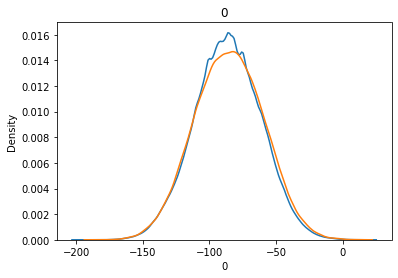

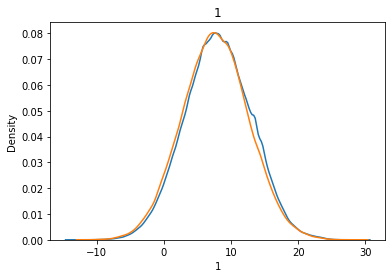

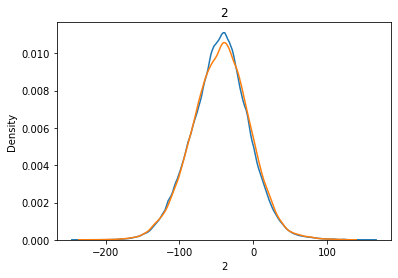

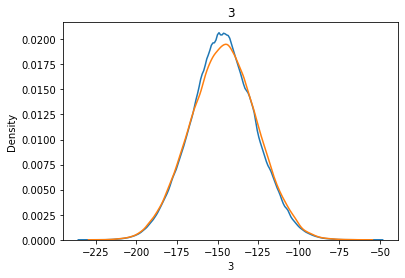

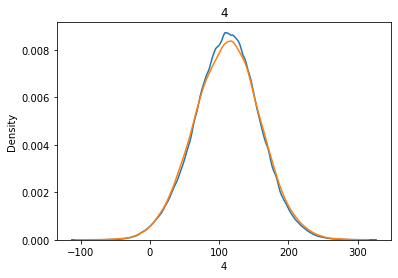

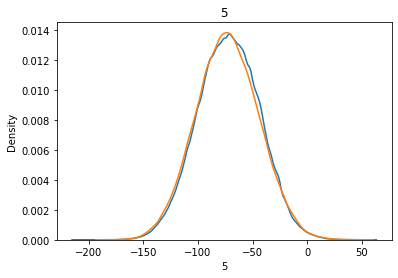

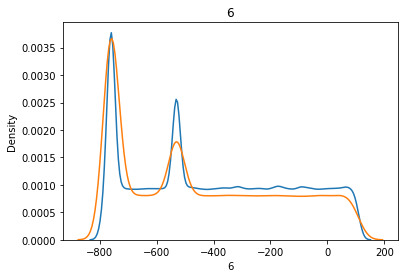

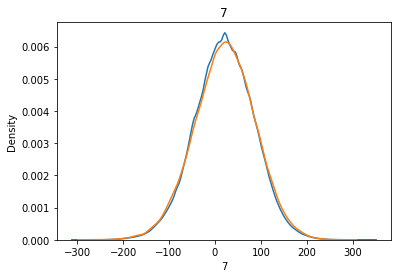

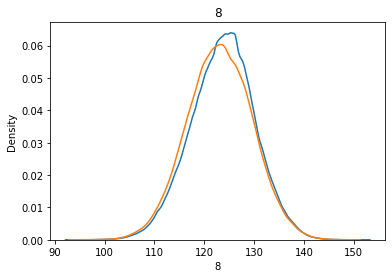

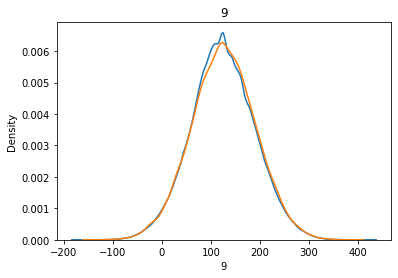

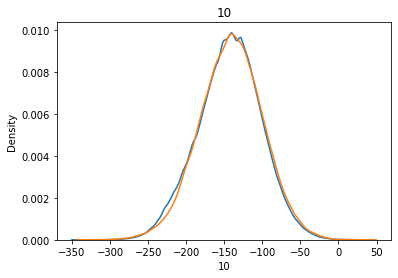

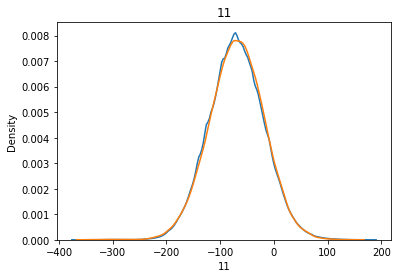

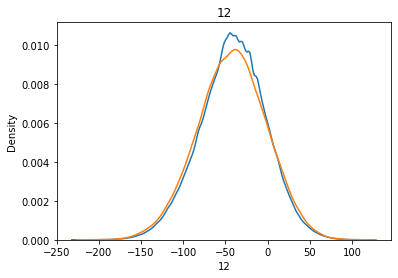

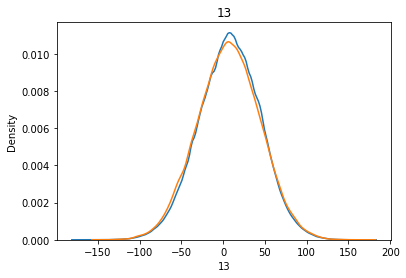

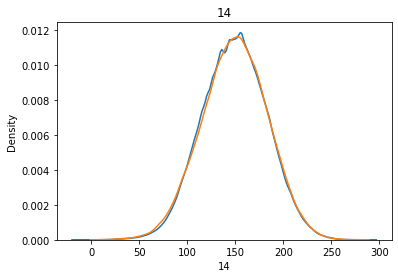

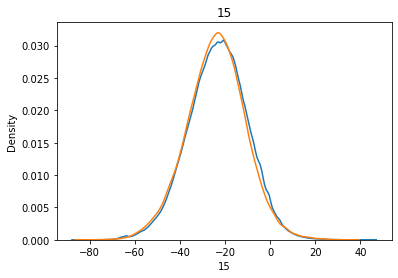

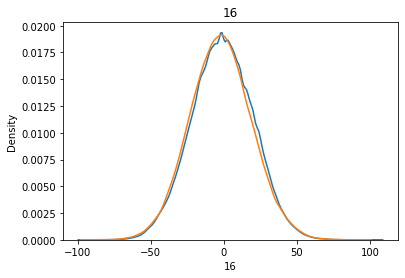

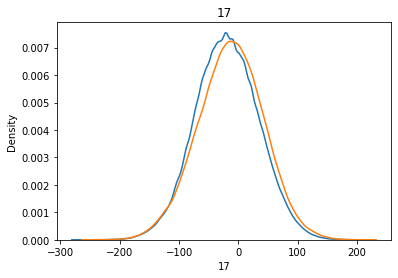

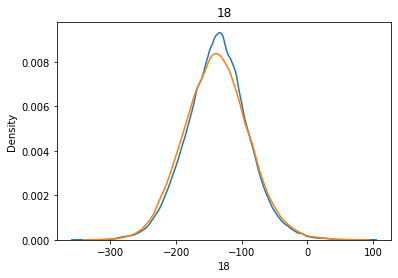

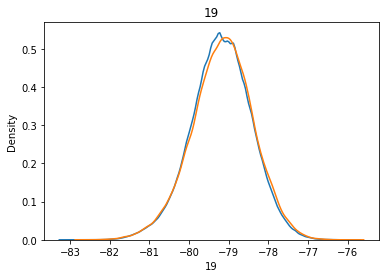

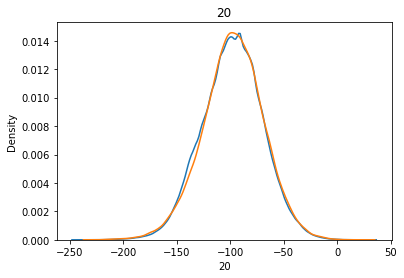

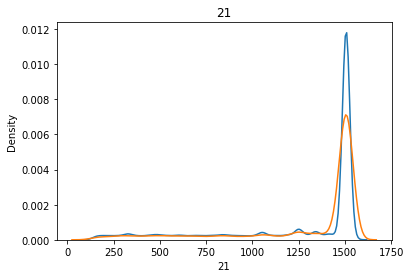

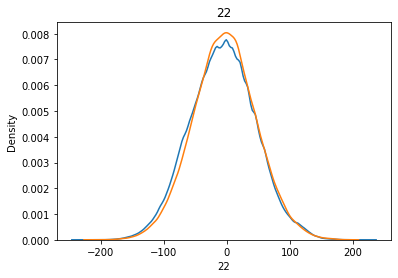

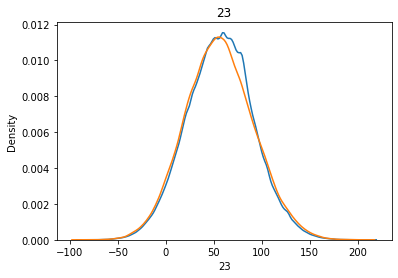

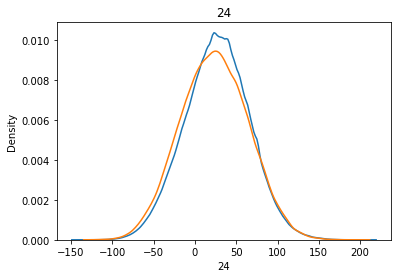

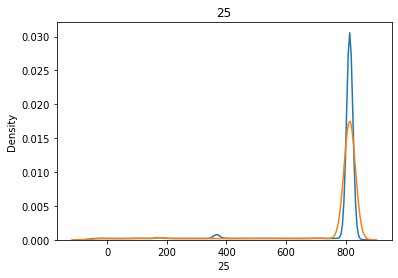

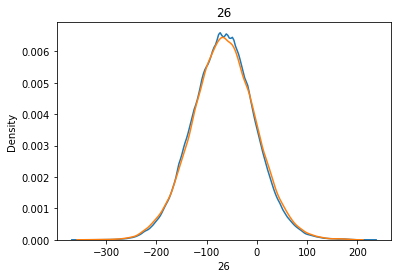

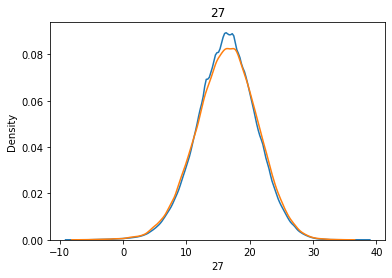

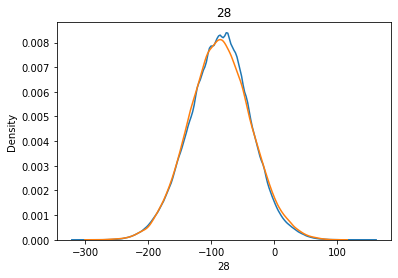

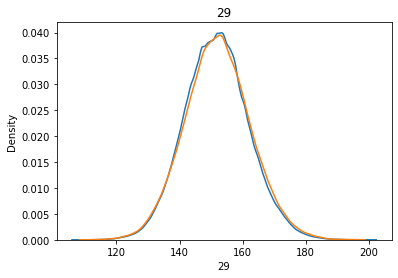

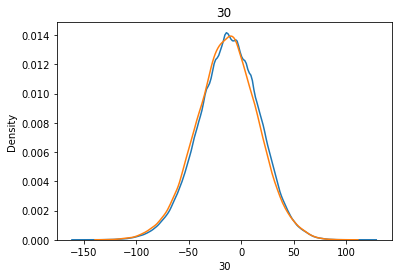

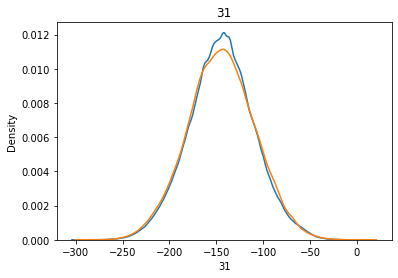

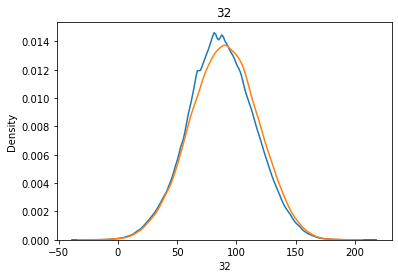

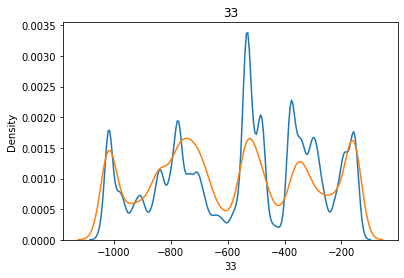

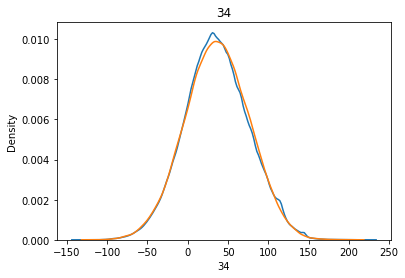

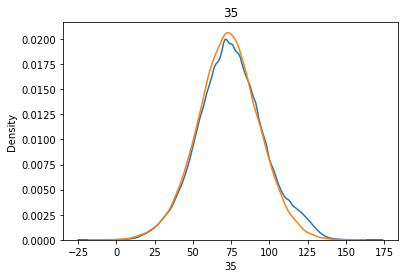

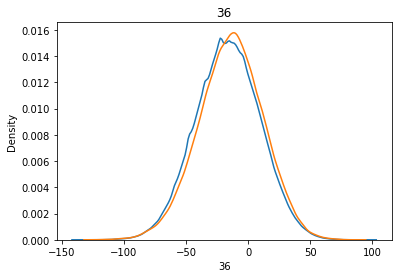

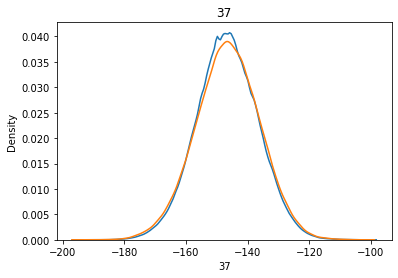

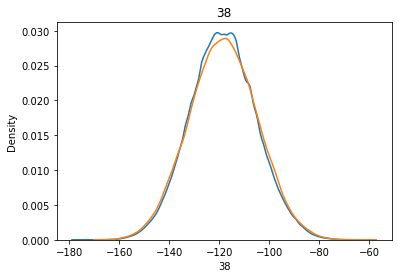

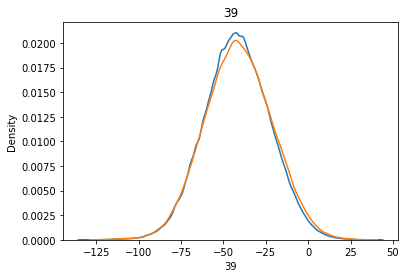

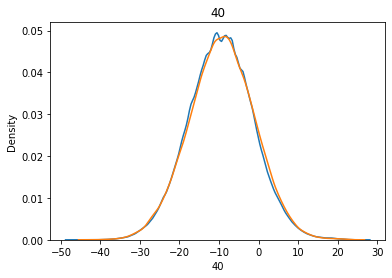

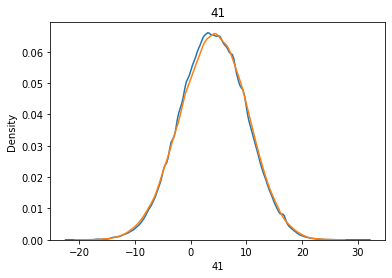

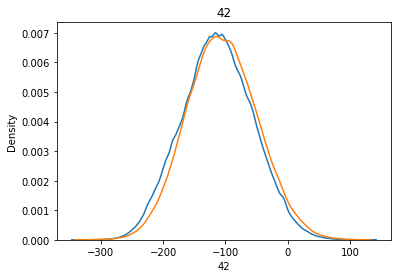

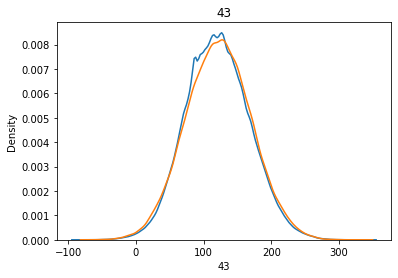

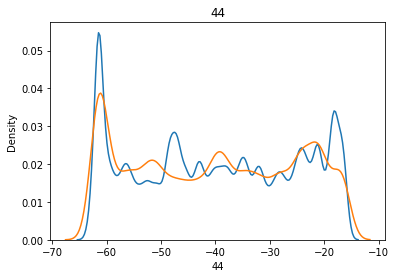

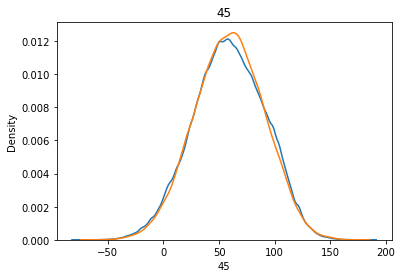

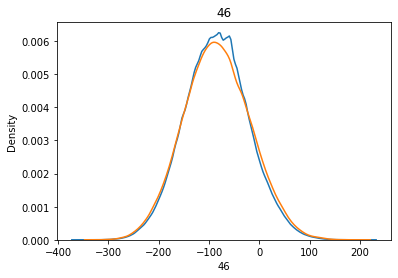

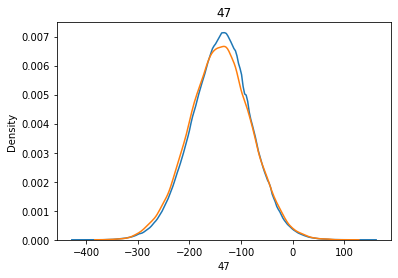

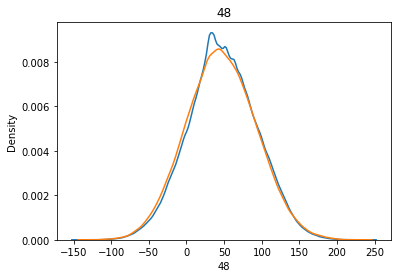

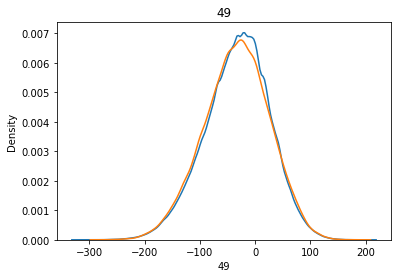

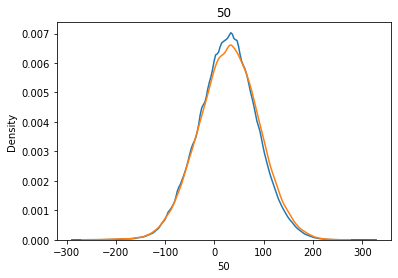

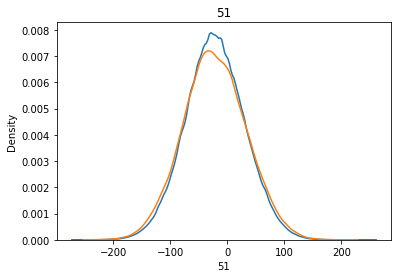

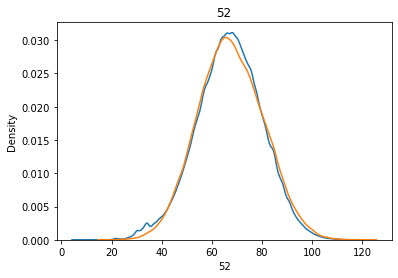

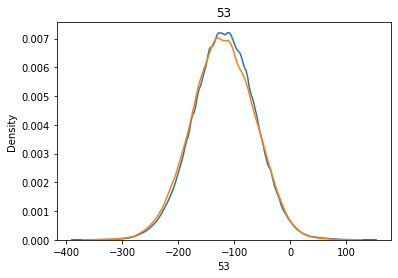

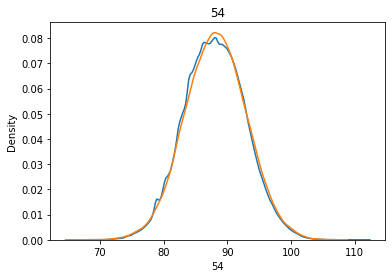

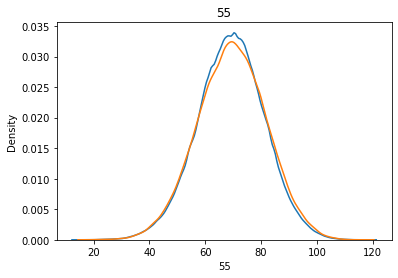

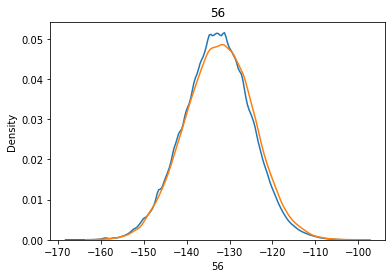

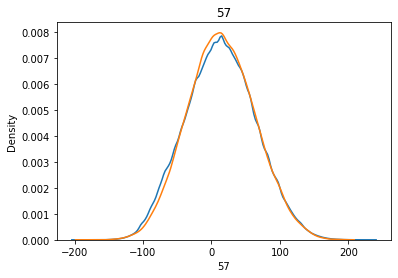

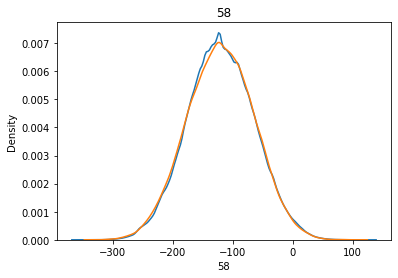

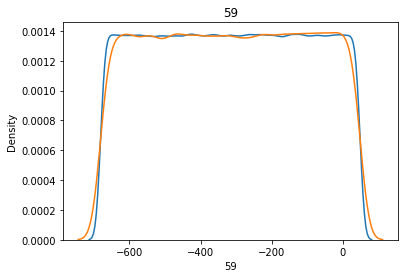

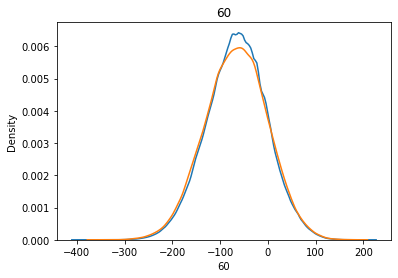

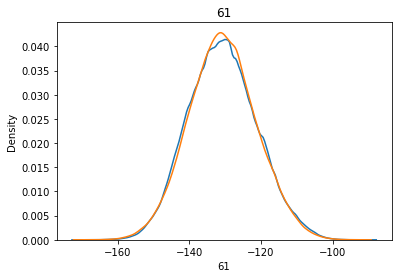

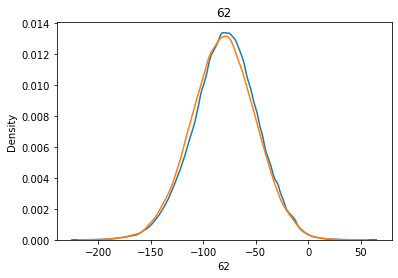

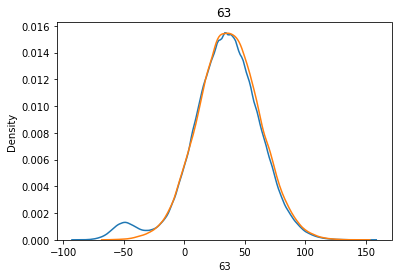

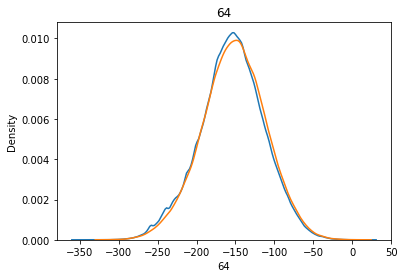

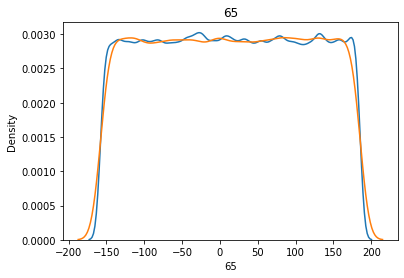

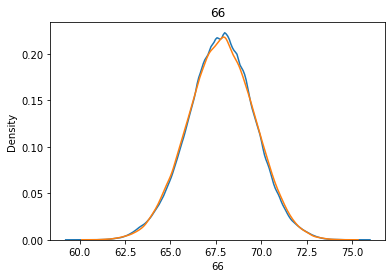

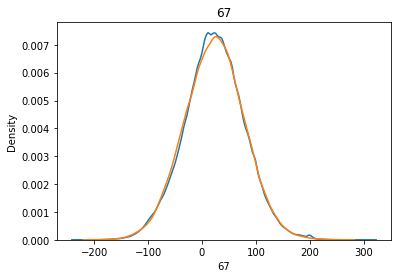

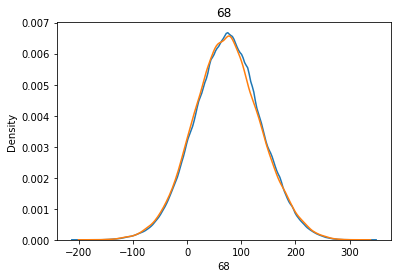

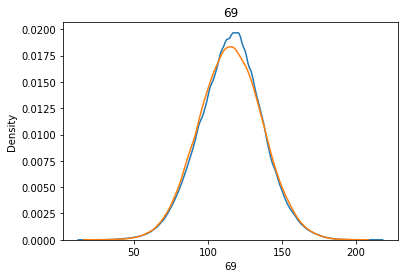

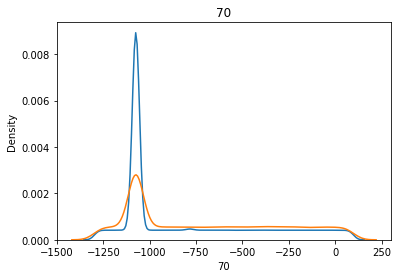

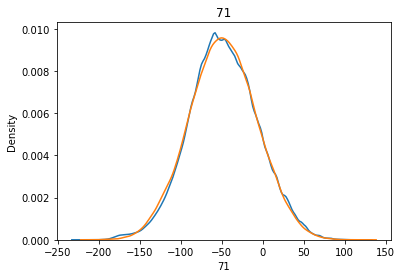

Wall time: 24min 45s


In [6]:
%%time

data_columns = df_base.columns 
for column in data_columns:
    plt.figure()
    sns.kdeplot(df_base.loc[:, column])
    sns.kdeplot(df_train.loc[:, column])
    plt.title(column)
    plt.show()

del column

Как мы видим, распределения в `df_base` и `df_train` совпадают, однако не во всех столбцах распределения являются нормальными, следовательно, для таких столбцов стоит выбрать другие типы нормализации, чтобы фичи были, так сказать,равны в возможностях своего влияния, когда мы их будем подавать в нашу модель.

Для столбцов с нормальным распределением будем применять `StandartScaler`, для для других же, а именно (столбцов '6', '33', '44', '21', '25', '59', '65', '70') будем использовать `RobustScaler`, `PowerTransformer` или `MinMaxScaler`, так как они являются лучшими нормализаторами для данных с ненормальным распределением, далее опытным путем определеим какой/какие лучший из них.

#### Performing scaling

In [7]:
%%time

nenormal_columns = ['6', '21', '25', '33', '44', '59', '65', '70']
normal_columns = [column for column in df_base.columns.to_list() if column not in (nenormal_columns)]

standart_scaler = StandardScaler()
df_base.loc[:, normal_columns] = standart_scaler.fit_transform(df_base.loc[:, normal_columns])

min_max_scaler = MinMaxScaler()
df_base.loc[:, nenormal_columns] = min_max_scaler.fit_transform(df_base.loc[:, nenormal_columns])

Wall time: 10.1 s


In [8]:
#взглянем на результат масштабирования
df_base

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-1.159216,0.620350,-0.513723,1.398558,2.269043,-1.160385,0.357783,0.373663,-0.435627,0.884544,...,1.189049,0.190524,0.073589,0.242799,-2.262493,-0.510438,0.293004,-0.014051,0.848552,-0.312329
1-base,2.075715,1.060423,-0.652491,-1.002705,-1.157244,-0.500495,0.783921,-0.871900,-0.623903,1.098487,...,-1.272135,0.270119,-0.073569,0.184269,0.225102,0.014491,1.711283,0.059848,0.868505,-0.281052
2-base,1.285417,-0.343342,0.397878,0.666228,0.853956,-0.973671,0.936658,0.654489,0.828686,0.619635,...,0.086191,0.440159,-1.269686,0.831416,-1.220546,0.773022,0.099669,0.048521,0.159996,0.365623
3-base,-0.051852,-0.816047,-1.118829,-1.936660,-0.754014,0.461441,0.453097,-0.840347,-0.259958,0.182763,...,0.274980,-1.372853,0.184217,0.349881,-0.871349,-0.797073,1.014714,0.090076,0.159996,-0.601807
4-base,0.541780,-0.314538,2.284450,0.303705,-2.276181,-1.422075,0.436974,0.386656,-0.238677,-0.191508,...,0.716557,0.808178,-0.110496,0.710664,-0.562342,-0.470720,-0.157210,0.920175,0.159996,1.152406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744755-base,-1.561060,-0.675221,2.145022,1.076266,2.124613,0.855791,0.181270,-1.423783,0.291078,-1.476259,...,0.284290,0.766146,-0.891135,0.818730,-1.248473,1.543466,-2.082561,0.079706,0.488245,-0.718053
4744759-base,-0.898663,-0.530123,0.579546,-0.608808,0.049398,-0.597886,0.748234,1.821418,0.845243,0.625420,...,0.284428,-0.514378,1.555805,0.376453,0.493593,-0.395871,-1.619490,-1.040661,0.159996,-1.030208
4744762-base,-0.433776,-2.064035,-0.690969,0.098481,0.823080,1.788798,0.035339,-2.001122,0.177137,-0.088426,...,0.757178,1.025621,-0.347378,0.776344,0.439465,0.355254,-0.096658,0.659732,0.159996,1.257774


### Create index

In [9]:
dims = df_base.shape[1]
n_cells = 5
# how many cells
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [10]:
idx_l2.train(np.ascontiguousarray(df_base.values[:500000, :]).astype('float32'))

idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [11]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [12]:
del df_base

## Train

In [13]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [14]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [15]:
#scaling
df_train.loc[:, normal_columns] = standart_scaler.transform(df_train.loc[:, normal_columns])
df_train.loc[:, nenormal_columns] = min_max_scaler.transform(df_train.loc[:, nenormal_columns])

In [16]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-query,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.492851,0.279598,-2.296794,-1.459626,...,-0.866975,1.274319,-0.024410,0.162328,-1.035388,0.197184,-0.200786,0.906575,0.631617,0.522963
1-query,-0.062146,-0.257159,0.324249,-1.543245,0.204684,-0.419328,0.773383,-1.538329,0.193777,0.246358,...,1.254600,-0.991073,0.075152,0.455089,0.207972,0.028031,0.244774,0.709459,0.188186,-0.083491
2-query,1.456328,-0.855696,-1.851792,-1.701553,1.700433,0.750504,0.908236,-0.791080,0.328335,1.352615,...,0.886224,1.548929,-0.348054,0.699574,-0.978114,-0.092956,2.240614,0.300576,0.159996,0.604677
3-query,1.543467,0.203199,-1.833235,1.291201,-0.359536,-1.322073,0.018111,0.916179,0.050167,1.834418,...,0.573141,0.388351,0.227494,0.734143,-2.007464,1.491032,0.133987,0.128028,0.159996,0.668019
4-query,0.265046,1.284537,-0.370748,-0.021041,-1.169187,1.977993,0.521752,0.399148,0.355099,-0.326947,...,0.336621,0.406133,-1.001615,0.116629,-0.474647,0.341715,0.043401,-1.090276,0.159996,0.638160


In [17]:
%%time
vecs_train, idx_train = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 5)

Wall time: 18min 7s


In [18]:
accuracy5_train = 0
for target, el_train in zip(targets.values.tolist(), idx_train.tolist()):
    accuracy5_train += int(target in [base_index[r] for r in el_train])

print(f'Accuracy@5 for train dataset: ', 100 * accuracy5_train / len(idx_train))

Accuracy@5 for train dataset:  64.504


In [19]:
del df_train, target, el_train, vecs_train, idx_train

## Validation

In [20]:
%%time

df_valid = pd.read_csv("D:/directory_practicum/product_recommendation_system/validation.csv", index_col=0)
answers = pd.read_csv("D:/directory_practicum/product_recommendation_system/validation_answer.csv", index_col=0)['Expected']

Wall time: 1.52 s


In [21]:
#scaling
df_valid.loc[:, normal_columns] = standart_scaler.transform(df_valid.loc[:, normal_columns])
df_valid.loc[:, nenormal_columns] = min_max_scaler.transform(df_valid.loc[:, nenormal_columns])

In [22]:
%%time
vecs_valid, idx_valid = idx_l2.search(np.ascontiguousarray(df_valid.values).astype('float32'), 5)

Wall time: 18min 12s


In [23]:
accuracy5_valid = 0
for answer, el_valid in zip(answers.values.tolist(), idx_valid.tolist()):
    accuracy5_valid += int(answer in [base_index[r] for r in el_valid])

print(f'Accuracy@5 for validation dataset:',100 * accuracy5_valid / len(idx_valid))

Accuracy@5 for validation dataset: 64.304


# Вопросы

1) Я, к сожалению, не понял, как можно реализовать здесь модель машинного обучения, например, Catboost, для того чтобы улучшить метрики. Объясню, как я это понял, вот мы берем не 5 ближайших соседей, а 100. Дальше возникает вопрос, зачем нам еще одна модель, если при поиске 5 ближайших соседей мы находим самые ближайшие вектора из `df_base`, то лучшего результата не получится достичь?

2) Правильно ли я сделал, что для разных столбцов в зависимости от их распределения выбрал разные нормализаторы для масштабирования данных, с учетом того, что качество модели улучшилось, примерно, на 10 пунктов? Можете, пожалуйста, скинуть полезные материалы по данному вопросу.